In [41]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data  # 获取迭代数据
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch.autograd import Variable  # 获取变量
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import models as m
from torchinfo import summary
import torchmetrics

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import numpy as np
import pandas as pd

import datetime
import time

import os
import sys

import cooler

from tqdm.notebook import trange, tqdm

https://www.kaggle.com/code/shtrausslearning/pytorch-cnn-binary-image-classification

In [2]:
# set root path. you can mark directory as source root in PyCharm to achieve the same purpose
project_root = os.path.join(os.path.abspath('.'), '..')
sys.path.insert(0, project_root)

In [3]:
# parse the configure parameters
# from config.config_parser import config_parser

# parser = config_parser()
# args = parser.parse_args(args=['--config', project_root + '/config/test.txt'])
# args.netdepth

In [4]:
#setting
batch_size = 64

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## load data

In [21]:
#raw data
# all_data = np.load("../input_data/data_imputation.npy")
# all_label = np.load("../input_data/label_imputation_binary.npy")

#imputed data
all_data = np.load("../input_data/data.npy")
all_label = np.load("../input_data/label.npy")

#转成二分类的
all_label[all_label != 0] = 1

In [22]:
#pack to dataset
all_data = torch.from_numpy(all_data).to(device)
all_label = torch.from_numpy(all_label).to(device)

#数据类型转换
all_data = all_data.float()
all_label = all_label.long()
#pack to dataset
dataset = TensorDataset(all_data, all_label)


In [23]:
#split 
seed = 30
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

num_train = int(len(dataset) * train_ratio)
num_validation = int(len(dataset) * validation_ratio)
num_test = int(len(dataset) - num_train - num_validation)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [num_train, num_validation, num_test],
                                                               torch.Generator().manual_seed(seed))
#Load to DataLoader
print("train_dataset:", len(train_dataset))
print("validation_dataset:", len(validation_dataset))
print("test_dataset:", len(test_dataset))
print("batch_size:", batch_size)

#load to dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



train_dataset: 9896
validation_dataset: 3298
test_dataset: 3300
batch_size: 64


## model

O = (I-K+2P)/S + 1

### EagleC

In [8]:
class EagleC_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #卷积
        self.features_ = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
                                       , nn.ReLU(inplace=True)
                                       , nn.MaxPool2d(2)

                                       , nn.Conv2d(32, 64, 3, stride=1, padding=1)
                                       , nn.ReLU(inplace=True)
                                       , nn.MaxPool2d(2)
                                       )
        #分类
        #根据net输出的形状确定
        self.clf_ = nn.Sequential(nn.Dropout(0.5)
                                  , nn.Linear(64 * 5 * 5, 512)
                                  , nn.ReLU(inplace=True)
                                  , nn.Linear(512, 2)
                                  , nn.Sigmoid()
                                  )

    def forward(self, x):
        x = self.features_(x)  #用特征提取的架构提取特征
        x = x.view(-1, 64 * 5 * 5)  #调整数据结构，拉平数据
        output = self.clf_(x)
        return output

### Simple net

In [34]:
class example_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        #全连接层
        self.fc1 = nn.Linear(64, 20)
        self.fc2 = nn.Linear(20, 10)
        #TODO：暂时设计为二分类
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  #展开
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

### Resnet

In [10]:
resnet18_ = m.resnet18()
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
            , resnet18_.bn1
            , resnet18_.relu
        )
        self.block2 = resnet18_.layer2  #128*11*11
        self.block3 = resnet18_.layer3  #256*6*6
        #自适应平均池化+线性层 
        self.avgpool = resnet18_.avgpool  #256*1*1
        #输出的线性层
        self.fc = nn.Linear(in_features=256, out_features=2, bias=True)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], 256)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## train

In [25]:
def save_checkpoints(epoch, net, optimizer, args):
    path = os.path.join(args.basedir, args.expname, '{:06d}.tar'.format(epoch))
    torch.save({
        'global_step': epoch,  # record current epoch for continue training
        'network_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print('Saved checkpoints at', path)

def IterOnce(net, criterion, opt, x, y):
    '''
    对模型进行一次迭代的函数
    net:实例化后的架构
    criterion:损失函数
    opt:优化器
    x:一个batch中所有的样本
    y:一个batch中所有样本的真实标签
    '''
    sigma = net.forward(x)
    loss = criterion(sigma, y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True)  #节省内存
    #预测的标签
    yhat = torch.max(sigma, 1)[1]
    correct = torch.sum(yhat == y)
    return correct, loss


#在测试数据上运行
def TestOnce(net, criterion, x, y):
    '''
    对一组数据进行测试并输出测试结果的函数
    net:训练之后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y:要测试的数据的真实标签
    '''
    with torch.no_grad():
        sigma = net.forward(x)
        loss = criterion(sigma, y)
        #最大的就是预测的标签
        yhat = torch.max(sigma, 1)[1]
        correct = torch.sum(yhat == y)
    return correct, loss


#提前停止
class EarlyStopping():
    ''' 
    在测试集上的损失连续几个epochs不再降低的时候，提前停止
    val_loss：测试集/验证集上这个epoch的损失
    '''

    def __init__(self, patience=5, tol=0.0005):
        ''' 
        patience:连续patience个epochs上损失不再降低的时候，停止迭代
        tol:阈值，当新损失与旧损失之间的差异小于tol时，认为模型不再提升
        '''
        self.patience = patience
        self.tol = tol
        self.counter = 0  #连续x次低于tol
        self.lowest_loss = None  #用于记录历史最低损失，在没有历史最低损失之前为None
        self.early_stop = False  #是否提前停止

    def __call__(self, val_loss):
        ''' 
        val_loss：外部输入的实际损失
        '''
        if self.lowest_loss == None:
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter, self.patience))

        if self.counter >= self.patience:
            self.early_stop = True
            print("\t NOTICE: Early stopping Activated")
        return self.early_stop


#训练与测试的函数
def fit_test(net, batchdata, testdata, criterion, opt, epochs, modelname, PATH, stop_mode=False,tol=0.005):
    ''' 
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率，以实现模型监控
    
    参数说明：
    net:实例化后的网络
    batchdata:使用DataLoader包装后的训练集
    testdata:使用DataLoader包装后的测试集
    criterion:损失函数
    opt:优化器
    epochs:训练的轮数
    tol:提前停止的阈值
    modelname:模型的名称
    PATH:模型的保存路径
    '''


    SamplePerEpoch = batchdata.dataset.__len__()
    allsamples = SamplePerEpoch * epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    trainacclist = []
    testacclist = []

    early_stopping = EarlyStopping(patience=5, tol=tol)
    highestacc = None

    # in order to train continue
    start = 1  


    # find checkpoints
    # if args.ft_path is not None and args.ft_path != 'None':
    #     ckpts = [args.ft_path]
    # else:
    #     ckpts = [os.path.join(args.basedir, args.expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if
    #              'tar' in f]
    # print('Found ckpts', ckpts)

    # if len(ckpts) > 0:
    #     ckpt_path = ckpts[-1]
    #     print('Reloading from', ckpt_path)
    #     ckpt = torch.load(ckpt_path)
    #     start = ckpt['global_step']
    #     opt.load_state_dict(ckpt['optimizer_state_dict'])

    #     # Load model
    #     net.load_state_dict(ckpt['net_state_dict'])


    for epoch in tqdm(range(start, epochs + 1)):
        #open train mode
        net.train()
        correct_train = 0
        loss_train = 0

        # if epoch % args.save_freq == 0:
        #     save_checkpoints(epoch, net, opt, args)

        for batch_idx, (x, y) in enumerate(batchdata):
            y = y.view(x.shape[0])
            #迭代一次的训练函数
            correct, loss = IterOnce(net, criterion, opt, x, y)
            #计算样本总量、总的correct与loss
            trainedsamples += x.shape[0]  #已经训练的样本数量

            correct_train += correct
            loss_train += loss

            #监控训练进程
            if (batch_idx + 1) % 100 == 0:
                print("\t Train Epoch: {} [{}/{} ({:.0f}%)]".format(epoch, trainedsamples, allsamples,
                                                                                   100. * trainedsamples / allsamples,
                                                                                ))

        TrainAccThisEpoch = float(correct_train * 100) / SamplePerEpoch
        TrainLossThisEpoch = float(loss_train * 100) / SamplePerEpoch
        trainlosslist.append(TrainLossThisEpoch)
        trainacclist.append(TrainAccThisEpoch)

        #测试
        #测试模式
        net.eval()

        #测试集上的准确率
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x, y in testdata:
            y = y.view(x.shape[0])  #调整shape
            correct, loss = TestOnce(net, criterion, x, y)
            #计算总的correct与loss
            correct_test += correct
            loss_test += loss

        TestAccThisEpoch = float(correct_test * 100) / TestSample
        TestLossThisEpoch = float(loss_test* 100) / TestSample
        testlosslist.append(TestLossThisEpoch)
        testacclist.append(TestAccThisEpoch)

        #对于每一个epoch，打印训练和测试结果
        print("\t Train Epoch: {} \t Train Loss: {:.6f} \t Train Acc: {:.2f}%".format(epoch, TrainLossThisEpoch,TrainAccThisEpoch))
        print("\t Test Epoch: {} \t Test Loss: {:.6f} \t Test Acc: {:.2f}%".format(epoch, TestLossThisEpoch,TestAccThisEpoch))

        #对于每一个epoch，保存测试集准确率最高的模型的权重
        if (highestacc == None) or (TestAccThisEpoch > highestacc):
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(), PATH + modelname + '.pt')
            print("\t NOTICE: Model Saved")

        #if early stopping is activated
        if stop_mode == True:
            early_stop = early_stopping(TestLossThisEpoch)
            if early_stop == True:
                print("\t NOTICE: Early Stopping Activated")
                #early stop
                break

    print("【DONE】")
    return trainlosslist, testlosslist, trainacclist, testacclist



#plot function
def plot_train_test(trainloss, valloss, trainacc, valacc):
    epochs = len(trainloss)
    fig,ax = plt.subplots(1,2,figsize=(15,5))

    sns.lineplot(x=[*range(1,epochs+1)],y=trainloss,ax=ax[0],label='loss_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=valloss,ax=ax[0],label='loss_hist["val"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=trainacc,ax=ax[1],label='acc_hist["train"]')
    sns.lineplot(x=[*range(1,epochs+1)],y=valacc,ax=ax[1],label='acc_hist["val"]')
    #xlabel
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')
    #ylabel
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Accuracy')
    #title
    
    



In [13]:
PATH = "/share/home/mliu/sc_sv/model"
modelname = "CNN"
print(modelname)
torch.manual_seed(1)

CNN


In [26]:
#Define model
# net = EagleC_CNN()
net = example_net()
# net = MyResNet()

criterion = nn.NLLLoss(reduction="sum")
# criterion = nn.CrossEntropyLoss(reduction="sum")


#优化算法
lrate = 0.0001
alpha = 0.99
gamma = 0
wd = 0

# opt = optim.RMSprop(net.parameters(), lr=args.lrate, alpha=alpha, momentum=gamma, weight_decay=wd)
opt = optim.Adam(params=net.parameters(), lr=lrate)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)
                                 
trainloss, valloss, trainacc, valacc = fit_test(net,train_loader, validation_loader, criterion, opt, epochs=10,
                                                        modelname=modelname, PATH=PATH,stop_mode=False)



	 Train Epoch: 1 [6400/98960 (6%)]
	 Train Epoch: 1 	 Train Loss: 77.649044 	 Train Acc: 17.71%
	 Test Epoch: 1 	 Test Loss: 67.947667 	 Test Acc: 46.82%
	 NOTICE: Model Saved
	 Train Epoch: 2 [16296/98960 (16%)]
	 Train Epoch: 2 	 Train Loss: 50.924859 	 Train Acc: 83.00%
	 Test Epoch: 2 	 Test Loss: 35.206491 	 Test Acc: 88.24%
	 NOTICE: Model Saved
	 Train Epoch: 3 [26192/98960 (26%)]
	 Train Epoch: 3 	 Train Loss: 34.034964 	 Train Acc: 87.45%
	 Test Epoch: 3 	 Test Loss: 31.911755 	 Test Acc: 88.24%
	 Train Epoch: 4 [36088/98960 (36%)]
	 Train Epoch: 4 	 Train Loss: 33.377119 	 Train Acc: 87.45%
	 Test Epoch: 4 	 Test Loss: 31.762491 	 Test Acc: 88.24%
	 Train Epoch: 5 [45984/98960 (46%)]
	 Train Epoch: 5 	 Train Loss: 33.244256 	 Train Acc: 87.45%
	 Test Epoch: 5 	 Test Loss: 31.570611 	 Test Acc: 88.24%
	 Train Epoch: 6 [55880/98960 (56%)]
	 Train Epoch: 6 	 Train Loss: 33.128932 	 Train Acc: 87.45%
	 Test Epoch: 6 	 Test Loss: 31.473057 	 Test Acc: 88.24%
	 Train Epoch: 7 [6577

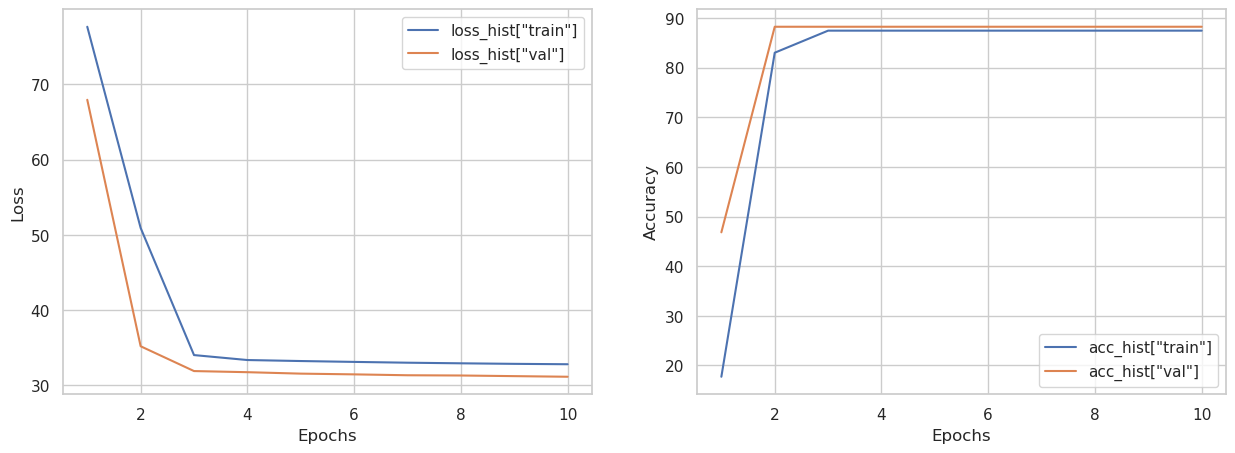

In [27]:
plot_train_test(trainloss, valloss, trainacc, valacc)

In [19]:
import torchmetrics


def test_loop(dataloader, model):
    # 实例化相关metrics的计算对象
    test_acc = torchmetrics.Accuracy(task="binary")
    test_recall = torchmetrics.Recall(task="binary", average='none')
    test_precision = torchmetrics.Precision(task="binary", average='none')
    # test_auc = torchmetrics.AUROC(task="binary",average="macro", num_classes=10)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            # 一个batch进行计算迭代
            test_acc(pred.argmax(1), y)
            # test_auc.update(pred, y)
            test_recall(pred.argmax(1), y)
            test_precision(pred.argmax(1), y)

    test_loss /= num_batches
    correct /= size

    # 计算一个epoch的accuray、recall、precision、AUC
    total_acc = test_acc.compute()
    total_recall = test_recall.compute()
    total_precision = test_precision.compute()
    # total_auc = test_auc.compute()
    print(f"Accuracy: {(100 * correct):>0.1f}%, ")
    print("Recall", total_recall)
    print("Precision", total_precision)
    print("F1", 2 * total_recall * total_precision / (total_recall + total_precision))
    # print("auc:", total_auc.item())

    # 清空计算对象
    test_precision.reset()
    test_acc.reset()
    test_recall.reset()
    # test_auc.reset()

In [28]:
test_loop(test_loader, net)

Accuracy: 88.3%, 
Recall tensor(1.)
Precision tensor(0.8830)
F1 tensor(0.9379)


## Predict

输入的不是21*21的小矩阵，而是全基因组的contact map (先只做intra的，所以输入的是intra的完整的contact map)

把这个完整的contact map(假设是n\*n的)，分成x个21\*21的矩阵，对每一个小的矩阵来说：

先prefilter，如果这个小矩阵太稀疏，直接判定为没有SV。如果符合prefilter的条件，用训练好的模型对其进行预测。

（这个prefilter其实有点artificial的）

这样就得到了很多个小矩阵的【分类】结果。

然后！用DBSCAN聚类，鉴别出local clusters，对于每个cluster，那个probability score最高的像素，被认为是SV的breakpoint

另一种策略，用CFSFDP聚类，鉴别出cluster的中心

其实感觉用k-means就可以了，因为cluster并没有复杂的pattern?



In [29]:
#输入测试数据
#输入的应该是一个细胞的，所有染色体的intra的contact map
#最好是不同来源的实验的？
cell_path = "/share/home/mliu/sc_sv/raw_data/scihic/K562/cooler/K562-AAGCCGGTAAGCCATC.mcool::/resolutions/100000"
cell_clr = cooler.Cooler(cell_path)

In [30]:
#TODO:还需要再完善
def prefilter(sub_matrix, zero_threshold=5): 
    """
    prefilter the matrix to remove the low quality data
    :param sub_matrix: the submatrix of the contact map
    :param threshold: the threshold of the prefilter
    :return: Bool
    """
    #sub_matrix non-zero number
    non_zero_num = np.count_nonzero(sub_matrix) 
    if non_zero_num <= zero_threshold:
        return False
    return True   

In [87]:
zero_threshold = 5
def check_whole_matrix(chr,matrix,window,zero_threshold):
    """
    check the whole matrix to find the valid region
    :param matrix: the matrix of the contact map
    :param window: the window size
    :return: the valid region
    """
    print(f"shape of {chr} matrix is {matrix.shape}")
    sv_list = []
    num = 0
    num_prefilter = 0
    num_candidate = 0
    for i in range(0, matrix.shape[0] - window, window):
        for j in range(0, matrix.shape[1] - window, window):
           
            
            sub_matrix = matrix[i:i + window, j:j + window]
            num += 1
            if prefilter(sub_matrix,zero_threshold):
                 #中心点的坐标
                c_x = i + window // 2
                c_y = j + window // 2
                
                num_prefilter += 1
                #predict result
                #TODO:需要先包装成tensor
                
     
                input_tensor = torch.as_tensor(sub_matrix).float().reshape(1,1,window,window)
                with torch.no_grad():
                    y_test_out = net(input_tensor)
                    y_test_pred = np.argmax(y_test_out,axis=1)
                    y_test_value = np.exp(y_test_out)
             
                
                #得到相应的坐标
                if y_test_pred == 1:
                    num_candidate += 1
                    sv_list.append([c_x,c_y])
                
    
    print(f"There are {num} small matrix")
    print(f"There are {num_prefilter} matirx to be predicted")
    print(f"There are {num_candidate} candidate SV")
    #返回sv的list
    return sv_list

def index2pos(sv_pos_list,cell_clr,resolution):
    x_list = [i[0] for i in sv_pos_list]
    y_list = [i[1]  for i in sv_pos_list]
    x_pos = cell_clr.bins().fetch("chr1")["start"][x_list].values.tolist()
    x_pos = [i+resolution//2 for i in x_pos]
    y_pos = cell_clr.bins().fetch("chr1")["start"][y_list].values.tolist()
    y_pos = [i+resolution//2 for i in y_pos]
    return x_pos,y_pos
    

In [101]:
#TODO:先用DBSCAN试试
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)


def cluster_poinst(x_pos,y_pos,plot=False):
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(x_pos, y_pos, s=10)
        format_ticks(ax)
        
    return x_pos,y_pos


shape of chr1 matrix is (2493, 2493)
There are 13924 small matrix
There are 35 matirx to be predicted
There are 35 candidate SV


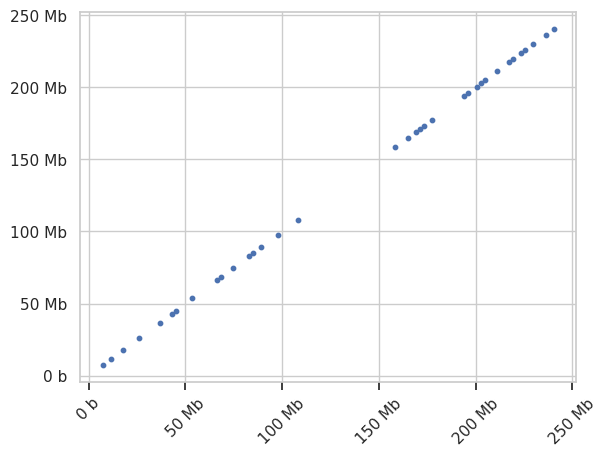

In [103]:
#遍历每个染色体，取intra的contact map
window = 21
zero_threshold = 3
for chr in cell_clr.chromnames:
    #fetch chr matrix
    chr_matrix = cell_clr.matrix(balance=False).fetch(chr)
    sv_pos_list = check_whole_matrix(chr,chr_matrix,window,zero_threshold)
    #转成坐标
    x_pos,y_pos = index2pos(sv_pos_list,cell_clr,100000)
    sv_pos_list = cluster_poinst(x_pos,y_pos,plot=True)
    #根据index，得到对应的坐标
    

    break

In [76]:
cell_clr.bins().fetch("chr1")

,chrom,start,end
0,chr1,0,100000
1,chr1,100000,200000
2,chr1,200000,300000
3,chr1,300000,400000
4,chr1,400000,500000
...,...,...,...
2488,chr1,248800000,248900000
2489,chr1,248900000,249000000
2490,chr1,249000000,249100000
2491,chr1,249100000,249200000
